# **RNN Introduction**


## Importing required libraries


In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
#from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading and preprocessing the data
### Dataset 4-Deep learning/5-Time Series Forecasting (RNN)/LAB/ٌDatasets/traffic.csv

In [2]:
df = pd.read_csv('/content/drive/MyDrive/traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [6]:
df.tail()

,DateTime,Junction,Vehicles,ID
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224
48119,2017-06-30 23:00:00,4,12,20170630234


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


## Visualization

In [3]:
#filter data
filter_jun_data = df[df['Junction'] == 1]
filter_jun_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14592 entries, 0 to 14591
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  14592 non-null  object
 1   Junction  14592 non-null  int64 
 2   Vehicles  14592 non-null  int64 
 3   ID        14592 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 570.0+ KB


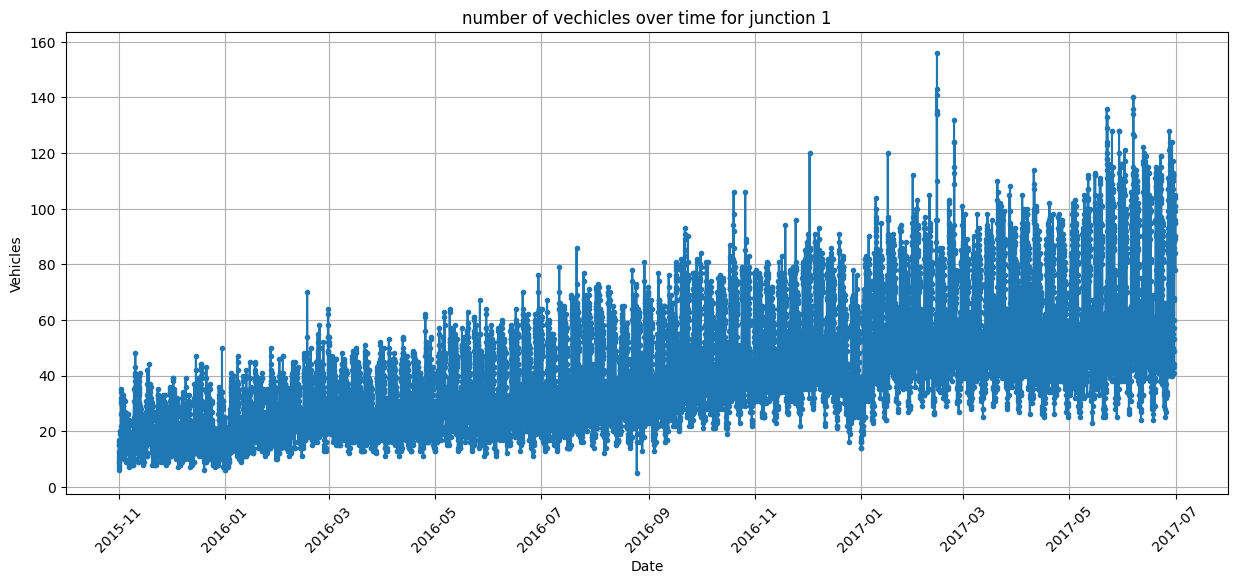

In [4]:
# Convert 'DateTime' column to datetime
filter_jun_data['DateTime'] = pd.to_datetime(filter_jun_data['DateTime'])

plt.figure(figsize=(15, 6))
plt.plot(filter_jun_data['DateTime'], filter_jun_data['Vehicles'], marker='.')
plt.title('number of vechicles over time for junction 1')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

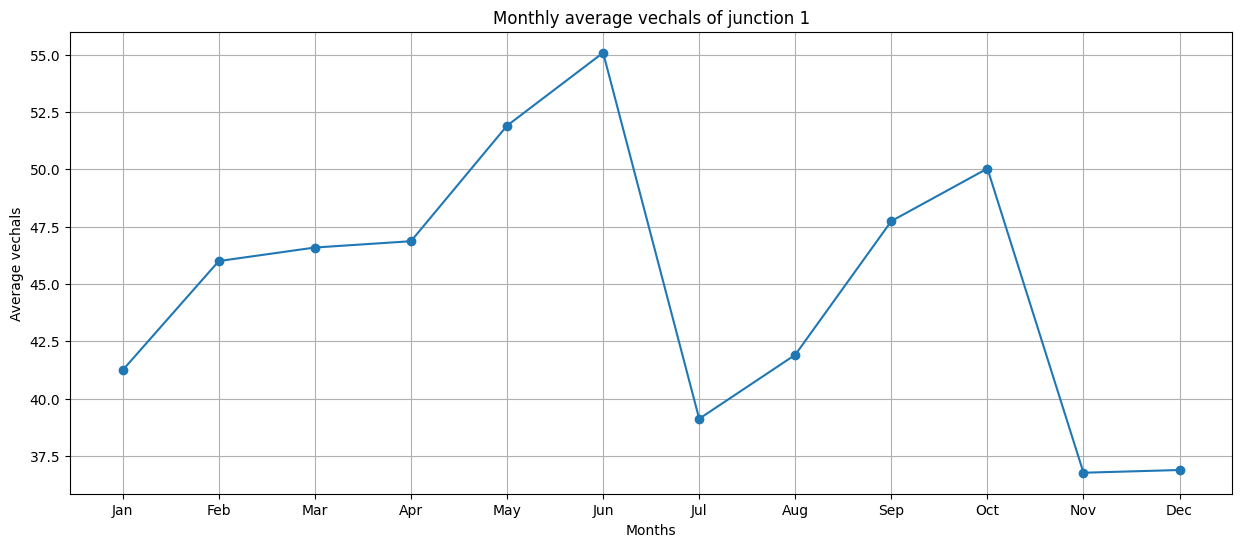

In [5]:
filter_jun_data['Month'] = filter_jun_data['DateTime'].dt.month

monthly_average = filter_jun_data.groupby('Month')['Vehicles'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly average vechals of junction 1')
plt.xlabel('Months')
plt.ylabel('Average vechals')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [6]:
new_df = filter_jun_data.reset_index()['Vehicles']

In [7]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

## Split the data into train and test

In [8]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [9]:
# Define the sequence length (number of past time steps)
n_past = 6

# Prepare sequences for RNN
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(11667, 6)
(11667,)


Testing set size:-
(2913, 6)
(2913,)


(None, None)

In [11]:
# Reshape input data for RNN([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Modeling RNN


In [12]:
# Initialize a sequential model
model = Sequential()

# First RNN layer with 30 units, input shape, and return sequences
model.add(SimpleRNN(units=30, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second RNN layer with 30 units and return sequences
model.add(SimpleRNN(units=30, return_sequences=True))
model.add(Dropout(0.2))

# Third RNN layer with 30 units
model.add(SimpleRNN(units=30))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 6, 30)               │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 30)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 6, 30)               │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 30)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,651 (18.17 KB)

 Trainable params: 4,651 (18.17 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our RNN model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=20,
          batch_size=64,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0521 - val_loss: 0.0045
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0072 - val_loss: 0.0035
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 10/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 11/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 12/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 9m

In [15]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [16]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [17]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

44.37490616878496
69.25711476015846


## Visualization of results


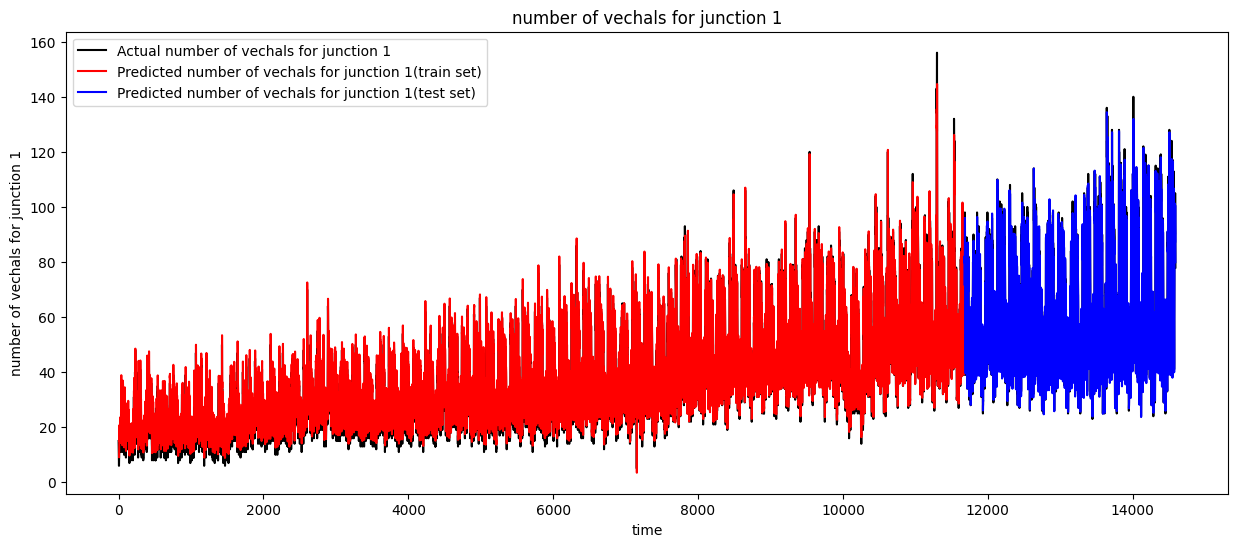

In [18]:
new_df_float = new_df.astype(float)
# Set the number of previous time steps to consider for plotting
look_back = 6

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(new_df_float, dtype=float)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(new_df_float)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(new_df_float) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual number of vechals for junction 1")
plt.plot(trainPredictPlot, color='red', label=f"Predicted number of vechals for junction 1(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted number of vechals for junction 1(test set)")

plt.title(f"number of vechals for junction 1")
plt.xlabel("time")
plt.ylabel(f"number of vechals for junction 1")
plt.legend()
plt.show()

#Modeling LSTM

In [19]:
from keras.layers import Dense, LSTM, Dropout, GRU

regressor = Sequential()

#first LSTM layer
regressor.add(LSTM(units=30, return_sequences =True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

regressor.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0100
Epoch 2/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0047
Epoch 3/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0028
Epoch 4/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0024
Epoch 5/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0022
Epoch 6/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0020
Epoch 7/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0020
Epoch 8/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0019
Epoch 9/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0017
Epoch 10/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0018


In [20]:
train_predict2=regressor.predict(X_train)
test_predict2=regressor.predict(X_test)

365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [21]:
train_predict2=scaler.inverse_transform(train_predict2)
test_predict2=scaler.inverse_transform(test_predict2)

In [22]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict2)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict2)))

43.651816303823594
68.93907574231504


#GRU **model**

In [23]:
#from tensorflow.keras.optimizers.legacy import SGD
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
regressorGRU = Sequential()

regressorGRU.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=30, activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(Dense(units=1))

regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

regressorGRU.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0193
Epoch 2/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0073
Epoch 3/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0071
Epoch 4/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0069
Epoch 5/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0068
Epoch 6/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0066
Epoch 7/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0063
Epoch 8/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0063
Epoch 9/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0063
Epoch 10/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0060


In [26]:
train_predict3=regressorGRU.predict(X_train)
test_predict3=regressorGRU.predict(X_test)

365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [27]:
train_predict3=scaler.inverse_transform(train_predict3)
test_predict3=scaler.inverse_transform(test_predict3)

In [28]:
print(math.sqrt(mean_squared_error(y_train,train_predict3)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict3)))

42.320047833797375
64.45151262736229
